In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import nltk
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

In [33]:
import warnings
warnings.simplefilter(action = "ignore")

### Step 1: Load and Inspect the Dataset
In this step, we will:
1. Load the train and test datasets.
2. Display the first few rows of each dataset.
3. Check the shape (number of rows and columns) of the datasets.
4. Examine the data types and look for missing vaues.


In [34]:
# Load the datasets
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

# Display the first few rows of the train dataset
print("First few rows of the train dataset:")
print(train_data.head())

# Display the first few rows of the test dataset
print("\nFirst few rows of the test dataset:")
print(test_data.head())

# Check the shape of the datasets
print("\nShape of the train dataset:", train_data.shape)
print("Shape of the test dataset:", test_data.shape)

# Check for missing values
print("\nMissing values in train dataset:")
print(train_data.isnull().sum())

print("\nMissing values in test dataset:")
print(test_data.isnull().sum())

First few rows of the train dataset:
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  

First few rows of the test dataset:
   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      Na

### Text Preprocessing Steps:
In this step, we will clean the text data by removing unnecessary elements that may not contribute to model performance. The steps include:

1. **Removing URLs**: Any links in the tweets will be removed as they do not add value to text analysis.
2. **Removing Mentions**: Text mentions in the `@username` format will be removed.
3. **Removing Special Characters and Numbers**: All non-alphabetic characters will be cleaned, leaving only letters.
4. **Converting to Lowercase**: The text will be converted to lowercase for consistency.
5. **Stripping Whitespaces**: Leading and trailing whitespaces will be removed.

This cleaned text will be stored in a new column called `cleaned_text` for both the train and test datasets.

In [35]:
# Function for cleaning text
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)    # Remove mentions
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and numbers
    text = text.lower()  # Convert to lowercase
    text = text.strip()  # Remove leading/trailing whitespace
    return text

# Apply the cleaning function to the 'text' column
train_data['cleaned_text'] = train_data['text'].apply(clean_text)
test_data['cleaned_text'] = test_data['text'].apply(clean_text)

# Display the first few rows to verify the cleaning process
print("Cleaned Training Data:")
print(train_data[['text', 'cleaned_text']].head())

print("\nCleaned Test Data:")
print(test_data[['text', 'cleaned_text']].head())

Cleaned Training Data:
                                                text  \
0  Our Deeds are the Reason of this #earthquake M...   
1             Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are ...   
3  13,000 people receive #wildfires evacuation or...   
4  Just got sent this photo from Ruby #Alaska as ...   

                                        cleaned_text  
0  our deeds are the reason of this earthquake ma...  
1              forest fire near la ronge sask canada  
2  all residents asked to shelter in place are be...  
3  people receive wildfires evacuation orders in ...  
4  just got sent this photo from ruby alaska as s...  

Cleaned Test Data:
                                                text  \
0                 Just happened a terrible car crash   
1  Heard about #earthquake is different cities, s...   
2  there is a forest fire at spot pond, geese are...   
3           Apocalypse lighting. #Spokane #wildfires   
4      Typ

### Exploratory Data Analysis (EDA) on Cleaned Text
In this step, we will perform exploratory analysis on the cleaned text data:
1. Analyze the distribution of text lengths (character count).
2. Analyze the distribution of word counts in the tweets.
3. Identify the most frequently occurring words in the cleaned text.

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\CaC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


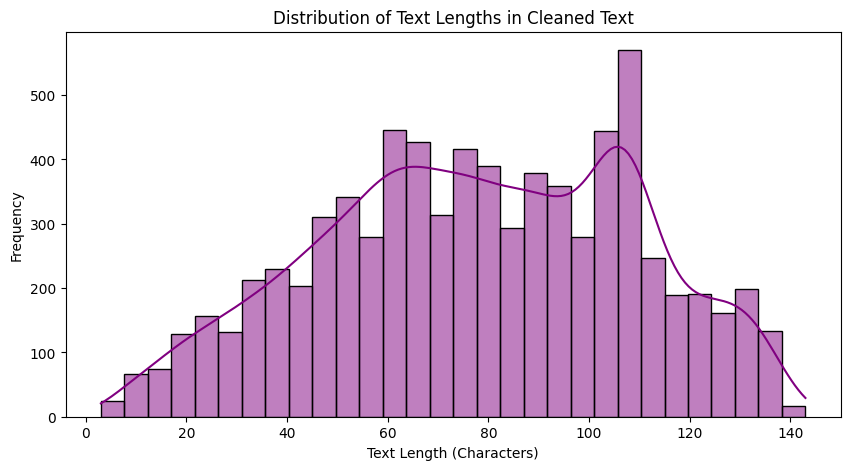

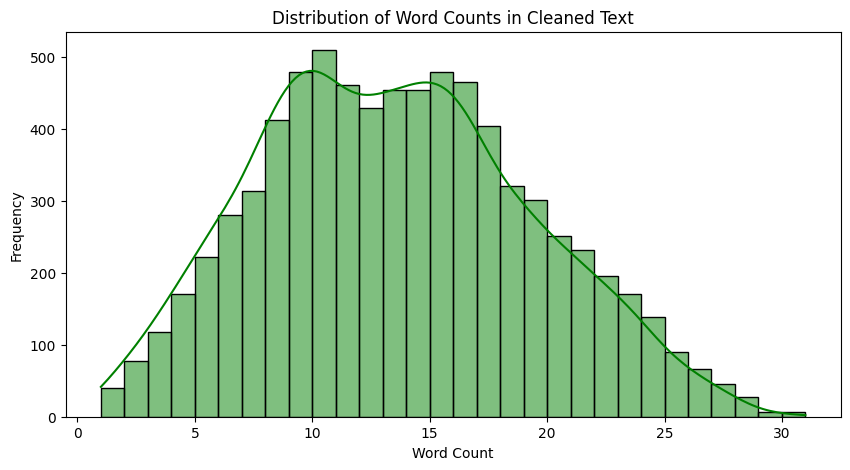

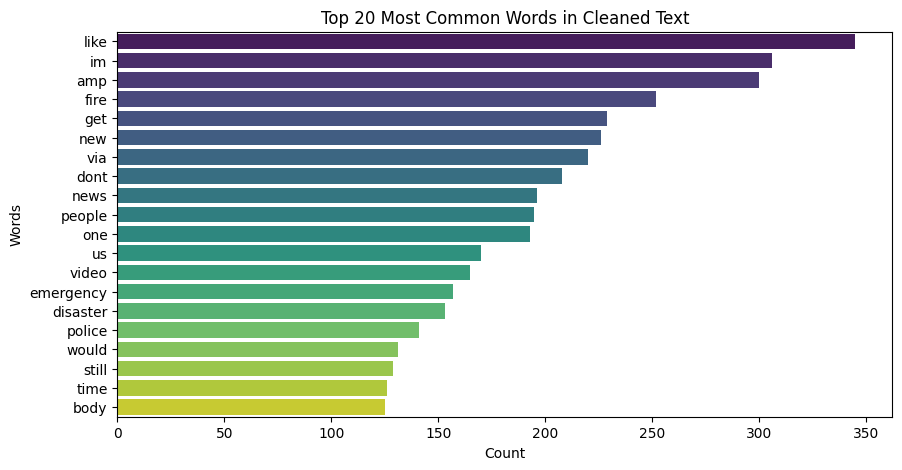

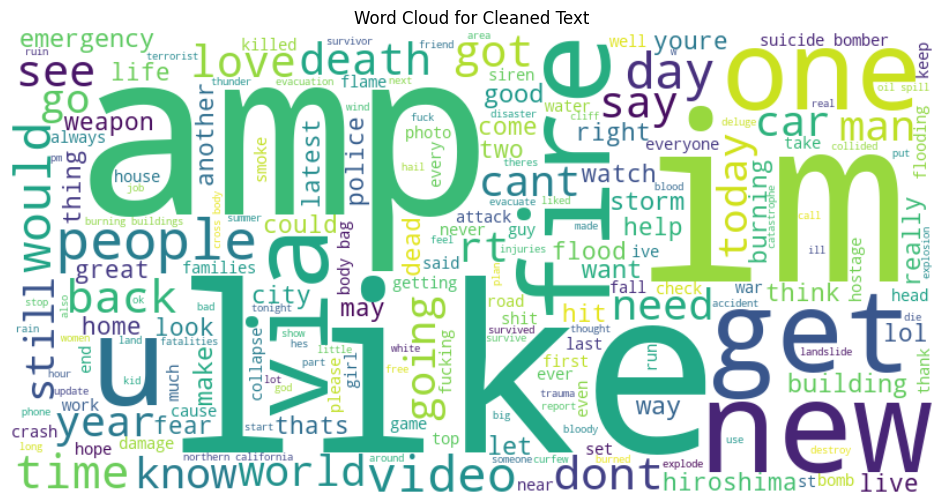

In [36]:
# Ensure necessary nltk packages are downloaded
nltk.download('stopwords')
from nltk.corpus import stopwords

# Stopwords for word analysis
stop_words = set(stopwords.words('english'))

### 1. Distribution of Text Lengths (Character Count)
train_data['text_length'] = train_data['cleaned_text'].apply(len)

plt.figure(figsize=(10, 5))
sns.histplot(train_data['text_length'], bins=30, kde=True, color='purple')
plt.title("Distribution of Text Lengths in Cleaned Text")
plt.xlabel("Text Length (Characters)")
plt.ylabel("Frequency")
plt.show()

### 2. Distribution of Word Counts
train_data['word_count'] = train_data['cleaned_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 5))
sns.histplot(train_data['word_count'], bins=30, kde=True, color='green')
plt.title("Distribution of Word Counts in Cleaned Text")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

### 3. Most Common Words in Cleaned Text (Excluding Stopwords)
def get_most_common_words(texts, n=20):
    words = [word for text in texts for word in text.split() if word not in stop_words]
    return Counter(words).most_common(n)

common_words = get_most_common_words(train_data['cleaned_text'], 20)

# Plot the most common words
words, counts = zip(*common_words)
plt.figure(figsize=(10, 5))
sns.barplot(x=list(counts), y=list(words), palette="viridis")
plt.title("Top 20 Most Common Words in Cleaned Text")
plt.xlabel("Count")
plt.ylabel("Words")
plt.show()

### 4. Word Cloud for Cleaned Text
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words).generate(" ".join(train_data['cleaned_text']))

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Cleaned Text")
plt.show()

### Feature Engineering - Text Length and Word Count  
In this step, we will add the following features to our dataset:  
1. **Text Length**: The number of characters in the "text" column.  
2. **Word Count**: The number of words in the "text" column.  

These features can help models better understand text complexity and structure.

In [37]:
# Add 'text_length' and 'word_count' features to the train and test datasets
train_data['text_length'] = train_data['text'].apply(len)
train_data['word_count'] = train_data['text'].apply(lambda x: len(x.split()))

test_data['text_length'] = test_data['text'].apply(len)
test_data['word_count'] = test_data['text'].apply(lambda x: len(x.split()))

# Display the first few rows to verify the new features
print("First few rows with new features in train dataset:")
print(train_data[['text', 'text_length', 'word_count']].head())

print("\nFirst few rows with new features in test dataset:")
print(test_data[['text', 'text_length', 'word_count']].head())

First few rows with new features in train dataset:
                                                text  text_length  word_count
0  Our Deeds are the Reason of this #earthquake M...           69          13
1             Forest fire near La Ronge Sask. Canada           38           7
2  All residents asked to 'shelter in place' are ...          133          22
3  13,000 people receive #wildfires evacuation or...           65           8
4  Just got sent this photo from Ruby #Alaska as ...           88          16

First few rows with new features in test dataset:
                                                text  text_length  word_count
0                 Just happened a terrible car crash           34           6
1  Heard about #earthquake is different cities, s...           64           9
2  there is a forest fire at spot pond, geese are...           96          19
3           Apocalypse lighting. #Spokane #wildfires           40           4
4      Typhoon Soudelor kills 28 in Chin

### Feature Engineering - Emoji Count and Uppercase Ratio  
In this step, we will add two additional features to our dataset:  
1. **Emoji Count**: The number of emojis in the "text" column.  
2. **Uppercase Ratio**: The ratio of uppercase characters to the total length of the text.  

These features can provide additional insights into the structure and tone of the text.

In [38]:
# Function to count emojis in a text
def count_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    return len(emoji_pattern.findall(text))

# Function to calculate uppercase ratio
def uppercase_ratio(text):
    total_chars = len(text)
    uppercase_chars = sum(1 for c in text if c.isupper())
    return uppercase_chars / total_chars if total_chars > 0 else 0

# Add emoji count and uppercase ratio to train and test datasets
train_data['emoji_count'] = train_data['text'].apply(count_emojis)
train_data['uppercase_ratio'] = train_data['text'].apply(uppercase_ratio)

test_data['emoji_count'] = test_data['text'].apply(count_emojis)
test_data['uppercase_ratio'] = test_data['text'].apply(uppercase_ratio)

# Display the first few rows to verify the new features
print("First few rows with additional features in train dataset:")
print(train_data[['text', 'emoji_count', 'uppercase_ratio']].head())

print("\nFirst few rows with additional features in test dataset:")
print(test_data[['text', 'emoji_count', 'uppercase_ratio']].head())

First few rows with additional features in train dataset:
                                                text  emoji_count  \
0  Our Deeds are the Reason of this #earthquake M...            0   
1             Forest fire near La Ronge Sask. Canada            0   
2  All residents asked to 'shelter in place' are ...            0   
3  13,000 people receive #wildfires evacuation or...            0   
4  Just got sent this photo from Ruby #Alaska as ...            0   

   uppercase_ratio  
0         0.144928  
1         0.131579  
2         0.015038  
3         0.015385  
4         0.034091  

First few rows with additional features in test dataset:
                                                text  emoji_count  \
0                 Just happened a terrible car crash            0   
1  Heard about #earthquake is different cities, s...            0   
2  there is a forest fire at spot pond, geese are...            0   
3           Apocalypse lighting. #Spokane #wildfires            0  

### TF-IDF Vectorization and Dataset Preparation  
In this step:  
1. The text column will be converted into numerical form using TF-IDF Vectorization.  
2. Additional numerical features such as emoji count, uppercase ratio, text length, and word count will be combined with the TF-IDF matrix.  
3. The final dataset will be prepared for model training and testing.

In [39]:
# TF-IDF Vectorization for the 'text' column
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limit to 5000 features for efficiency
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['text'])
X_test_tfidf = tfidf_vectorizer.transform(test_data['text'])

# Combine TF-IDF features with additional numerical features
additional_features_train = train_data[['text_length', 'word_count', 'emoji_count', 'uppercase_ratio']].values
additional_features_test = test_data[['text_length', 'word_count', 'emoji_count', 'uppercase_ratio']].values

# Combine sparse matrices
X_train_final = hstack((X_train_tfidf, additional_features_train))
X_test_final = hstack((X_test_tfidf, additional_features_test))

# Target variable
y_train = train_data['target']

# Check shapes
print("Shape of final training set:", X_train_final.shape)
print("Shape of final test set:", X_test_final.shape)

Shape of final training set: (7613, 5004)
Shape of final test set: (3263, 5004)


### Model Training and Evaluation  
In this step:  
1. We will train a Logistic Regression model using the prepared feature set.  
2. Evaluate the model performance using metrics like F1-Score, Accuracy, Precision, and Recall.  
3. Compare the performance with other models to determine the best-performing algorithm.  

In [40]:
# Split train data into train and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train_final, y_train, test_size=0.2, random_state=42)

# Initialize Logistic Regression Model
logreg = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
logreg.fit(X_train_split, y_train_split)

# Predict on validation set
y_pred = logreg.predict(X_val)

# Evaluate the model
print("Model Performance on Validation Set:")
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))
print("F1-Score:", f1_score(y_val, y_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

Model Performance on Validation Set:
Accuracy: 0.8168089297439265
Precision: 0.8315412186379928
Recall: 0.7149460708782742
F1-Score: 0.7688483844241922

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       874
           1       0.83      0.71      0.77       649

    accuracy                           0.82      1523
   macro avg       0.82      0.80      0.81      1523
weighted avg       0.82      0.82      0.81      1523



### Testing Additional Models
After evaluating Logistic Regression, we will now:
1. Train models like Random Forest and Naive Bayes.  
2. Compare the performance with Logistic Regression using accuracy, precision, recall, and F1-Score.  
3. Optimize model performance using hyperparameter tuning.  

In [41]:
# Initialize Random Forest Model
rf_model = RandomForestClassifier(random_state=42, n_estimators=200)

# Train the model
rf_model.fit(X_train_split, y_train_split)

# Predict on validation set
y_pred_rf = rf_model.predict(X_val)

# Evaluate the model
print("Random Forest Performance on Validation Set:")
print("Accuracy:", accuracy_score(y_val, y_pred_rf))
print("Precision:", precision_score(y_val, y_pred_rf))
print("Recall:", recall_score(y_val, y_pred_rf))
print("F1-Score:", f1_score(y_val, y_pred_rf))
print("\nClassification Report:")
print(classification_report(y_val, y_pred_rf))

Random Forest Performance on Validation Set:
Accuracy: 0.7774130006565988
Precision: 0.8384279475982532
Recall: 0.5916795069337443
F1-Score: 0.6937669376693767

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.92      0.83       874
           1       0.84      0.59      0.69       649

    accuracy                           0.78      1523
   macro avg       0.79      0.75      0.76      1523
weighted avg       0.79      0.78      0.77      1523



### Testing Multinomial Naive Bayes
After Random Forest and Logistic Regression, we test the Naive Bayes model:
1. Multinomial Naive Bayes is particularly effective for text data.
2. Compare the accuracy, precision, recall, and F1-Score with previous models.
3. Analyze if it improves the recall or overall balance of metrics.

In [42]:
# Initialize Naive Bayes Model
nb_model = MultinomialNB()

# Train the model
nb_model.fit(X_train_split, y_train_split)

# Predict on validation set
y_pred_nb = nb_model.predict(X_val)

# Evaluate the model
print("Multinomial Naive Bayes Performance on Validation Set:")
print("Accuracy:", accuracy_score(y_val, y_pred_nb))
print("Precision:", precision_score(y_val, y_pred_nb))
print("Recall:", recall_score(y_val, y_pred_nb))
print("F1-Score:", f1_score(y_val, y_pred_nb))
print("\nClassification Report:")
print(classification_report(y_val, y_pred_nb))

Multinomial Naive Bayes Performance on Validation Set:
Accuracy: 0.8010505581089954
Precision: 0.8352713178294574
Recall: 0.6640986132511556
F1-Score: 0.7399141630901288

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.90      0.84       874
           1       0.84      0.66      0.74       649

    accuracy                           0.80      1523
   macro avg       0.81      0.78      0.79      1523
weighted avg       0.81      0.80      0.80      1523



### Model Comparison and Evaluation

We tested three machine learning models on the validation set to classify disaster and non-disaster tweets. Below are the performance metrics, including **Accuracy**, **Precision**, **Recall**, and **F1-Score**:

---

#### **1. Logistic Regression**
- **Accuracy**: 81.68%
- **Precision**: 83.15%
- **Recall**: 71.49%
- **F1-Score**: 76.88%

**Observations**:  
Logistic Regression achieved the best overall performance with a balanced F1-Score and Recall. This makes it the most suitable model for ensuring disaster tweets are identified effectively without sacrificing overall accuracy.

---

#### **2. Random Forest**
- **Accuracy**: 77.74%
- **Precision**: 83.84%
- **Recall**: 59.17%
- **F1-Score**: 69.38%

**Observations**:  
Random Forest performed well in terms of **Precision** but significantly underperformed in **Recall**, meaning it missed many disaster-related tweets. This limits its effectiveness for our goal.

---

#### **3. Multinomial Naive Bayes**
- **Accuracy**: 80.10%
- **Precision**: 83.52%
- **Recall**: 66.40%
- **F1-Score**: 73.99%

**Observations**:  
Naive Bayes delivered a decent F1-Score but fell behind Logistic Regression. Its Recall is slightly better than Random Forest but still lower than Logistic Regression, making it less favorable overall.

---

### Conclusion

Among the three models tested:
- **Logistic Regression** stands out as the **best-performing model** with the highest F1-Score (76.88%) and balanced Precision and Recall.  
- While Random Forest and Naive Bayes have strengths, they are not as effective overall.

### Optimized Logistic Regression with TF-IDF and Hyperparameter Tuning

In this step, we use **TF-IDF vectorization** and apply **Logistic Regression** with **GridSearchCV** for hyperparameter optimization. Key highlights include:

1. **TF-IDF Vectorization**:
   - Converts text data into numerical form using `TfidfVectorizer`.
   - Parameters:
     - `max_features=10000`: Limits the vocabulary size to the top 10,000 words.
     - `ngram_range=(1, 2)`: Captures both single words (unigrams) and word pairs (bigrams).
     - `stop_words='english'`: Removes common English stop words.
     - `min_df=5`: Ignores terms that appear in fewer than 5 documents.

2. **Train-Validation Split**:
   - Data is split into training and validation sets using **stratified splitting** to ensure class balance.

3. **Logistic Regression with GridSearchCV**:
   - Hyperparameter optimization is performed using `GridSearchCV` with the following parameters:
     - `C`: Regularization strength (0.1, 1, 10).
     - `penalty`: Regularization type (`l1`, `l2`).
     - `solver`: Optimization algorithm (`liblinear`, `saga`).

4. **Model Evaluation**:
   - The optimized model is evaluated on the validation set using:
     - **Accuracy**
     - **F1-Score**
     - **Classification Report**

---

The final result will include:
- The **best hyperparameters** selected through GridSearchCV.
- Performance metrics of the optimized model on the validation set.
- This optimized model will be used to predict test data and generate the **submissioncsv** file for the competition.
and ready for final evaluation.


In [43]:
# TF-IDF Vectorization with optimized parameters
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), stop_words='english', min_df=5)
X_tfidf = tfidf.fit_transform(train_data['cleaned_text'])

# Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(X_tfidf, train_data['target'], test_size=0.2, random_state=42, stratify=train_data['target'])

# Logistic Regression Model with GridSearchCV
logreg = LogisticRegression(max_iter=300)
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best Parameters
print("Best Hyperparameters:", grid_search.best_params_)
print("Best F1-Score from GridSearchCV:", grid_search.best_score_)

# Evaluate on Validation Set
optimized_logreg = grid_search.best_estimator_
y_val_pred = optimized_logreg.predict(X_val)

print("\nOptimized Logistic Regression Performance on Validation Set:")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("F1-Score:", f1_score(y_val, y_val_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Hyperparameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best F1-Score from GridSearchCV: 0.730785740874199

Optimized Logistic Regression Performance on Validation Set:
Accuracy: 0.8227183191070256
F1-Score: 0.7757475083056479

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       869
           1       0.85      0.71      0.78       654

    accuracy                           0.82      1523
   macro avg       0.83      0.81      0.81      1523
weighted avg       0.83      0.82      0.82      1523



### Generating Predictions and Submission File

In this final step:
1. **TF-IDF Transformation**:
   - The `test_data` is transformed using the **TF-IDF vectorizer** that was previously fitted on the training data. This ensures consistency between the train and test feature spaces.

2. **Predictions on Test Data**:
   - The optimized **Logistic Regression model** is used to predict the **target** values for the test dataset.

3. **Creating Submission File**:
   - A submission file is generated in the required format with:
     - `id`: The IDs from the test data.
     - `target`: Predicted target values (0 or 1).
   - The submission file is saved as **`submission.csv`**.

This file is ready for submission to the competition platform.

In [44]:
# Transform the test dataset using the previously fitted TF-IDF vectorizer
X_test_tfidf = tfidf.transform(test_data['cleaned_text'])

# Predict target values for the test dataset using the optimized logistic regression model
test_preds = optimized_logreg.predict(X_test_tfidf)

# Create a submission file in the required format
submission = pd.DataFrame({'id': test_data['id'], 'target': test_preds})
submission.to_csv('submission.csv', index=False)
print("Submission file saved as submission.csv")

Submission file saved as submission.csv
